<a href="https://colab.research.google.com/github/MAALEVAISHNAVI/Major-Project/blob/main/ADHD_Screening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install Libraries
!pip install transformers datasets torch pandas scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [ ]:
# Step 3: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 4: Load and Preprocess the ADHD Dataset
def load_and_preprocess_adhd(path, sample_size=10000):
    df = pd.read_csv(path)
    print(f"Original ADHD rows: {len(df)}")

    # Remove rows where content is removed or deleted
    df = df[~df["selftext"].isin(["[removed]", "[deleted]"])]
    # Drop any rows with missing 'title' or 'selftext'
    df = df.dropna(subset=["title", "selftext"])

    # Combine 'title' and 'selftext' columns into one 'text' column
    df["text"] = df["title"].str.strip() + " " + df["selftext"].str.strip()
    # Truncate text to 256 characters for efficiency
    df["text"] = df["text"].str[:256]
    # Assign label 1 to ADHD posts
    df["label"] = 1

    # Randomly sample from dataset
    return df.sample(n=min(sample_size, len(df)), random_state=42)

In [ ]:
# Step 5: Load and Preprocess the Non-ADHD Dataset
def load_and_preprocess_non_adhd(path, sample_size=10000):
    df = pd.read_csv(path)
    print(f"Original non-ADHD rows: {len(df)}")

    # Use only the 'title' as text for this dataset
    df["text"] = df["title"].str.strip().str[:256]
    # Assign label 0 to non-ADHD posts
    df["label"] = 0

    # Randomly sample from dataset
    return df.sample(n=min(sample_size, len(df)), random_state=42)

In [ ]:
# Load datasets
df_adhd = load_and_preprocess_adhd("/content/drive/MyDrive/Project/ADHD.csv")
df_non_adhd = load_and_preprocess_non_adhd("/content/drive/MyDrive/Project/r_wallstreetbets_posts.csv")

<ipython-input-4-435ce888e673>:3: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Original ADHD rows: 336066


<ipython-input-5-7f3bc7a39db8>:3: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Original non-ADHD rows: 1118863


In [ ]:
# Step 6: Combine ADHD and Non-ADHD DataFrames
full_df = pd.concat([df_adhd[["text", "label"]], df_non_adhd[["text", "label"]]])

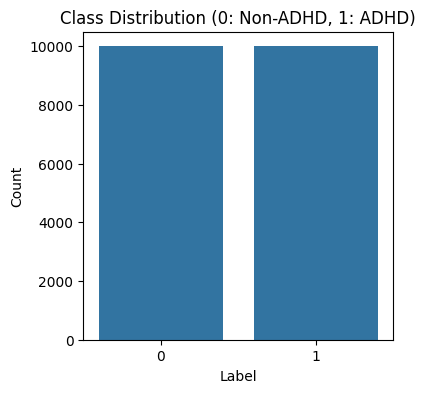

In [ ]:
# Plot class distribution
plt.figure(figsize=(4, 4))
sns.countplot(x='label', data=full_df)
plt.title('Class Distribution (0: Non-ADHD, 1: ADHD)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# Step 7: Dataset Summary
print("Dataset Summary:")
print(f"Total samples: {len(full_df)}")
print(f"ADHD samples: {len(full_df[full_df['label']==1])}")
print(f"Non-ADHD samples: {len(full_df[full_df['label']==0])}")

Dataset Summary:
Total samples: 20000
ADHD samples: 10000
Non-ADHD samples: 10000


In [ ]:
# Split the data into training and testing
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42, stratify=full_df['label'])

In [ ]:
# Step 8: Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Convert DataFrames to HuggingFace Datasets format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Tokenization function to encode texts
def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

# Apply tokenization
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:
# Step 9: Define Evaluation Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds)
    }

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.037500,0.034977,0.992750
2,0.016800,0.021285,0.996000
3,0.003500,0.023270,0.996750


TrainOutput(global_step=6000, training_loss=0.026606488823890686, metrics={'train_runtime': 2419.8351, 'train_samples_per_second': 19.836, 'train_steps_per_second': 2.48, 'total_flos': 6314665328640000.0, 'train_loss': 0.026606488823890686, 'epoch': 3.0})

In [ ]:
# Step 10: Evaluate the model
results = trainer.evaluate()
# Print Accuracy
print(f"Evaluation Accuracy: {results['eval_accuracy']:.4f}")

Evaluation Accuracy: 0.9960


In [ ]:
# Step 11: Generate Comprehensive Classification Report Separately
print("\nGenerating evaluation report...")
# Get predictions
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = tokenized_test['label']
# Classification Report
print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(true_labels, preds,
                          target_names=['Non-ADHD', 'ADHD'],
                          digits=4))


Generating evaluation report...



Classification Report
              precision    recall  f1-score   support

    Non-ADHD     0.9940    0.9980    0.9960      2000
        ADHD     0.9980    0.9940    0.9960      2000

    accuracy                         0.9960      4000
   macro avg     0.9960    0.9960    0.9960      4000
weighted avg     0.9960    0.9960    0.9960      4000



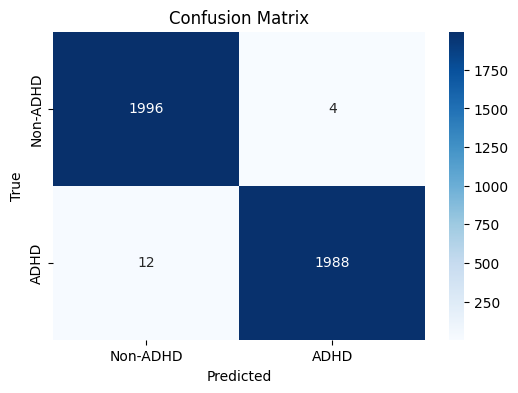

In [ ]:
# Step 12: Plot Confusion Matrix
cm = confusion_matrix(true_labels, preds)

# Plotting the Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-ADHD', 'ADHD'],
            yticklabels=['Non-ADHD', 'ADHD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Step 11: Save Model
model.save_pretrained("/content/drive/MyDrive/ADHD_Screening/adhd_bert_model")
tokenizer.save_pretrained("/content/drive/MyDrive/ADHD_Screening/adhd_bert_tokenizer")
print("Model saved successfully!")

Model saved successfully!
